$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
#device = 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/adihorowitz/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/adihorowitz/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/adihorowitz/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


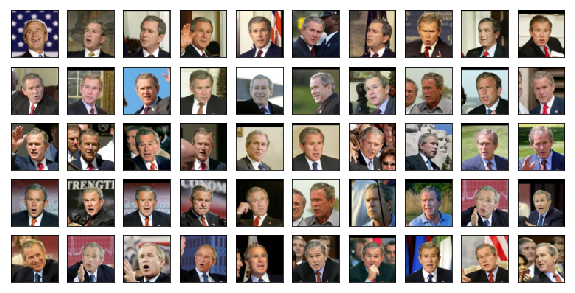

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 250, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=16000, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 250, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(250, 500, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(500, 750, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(750, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(750, 1000, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(1000, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
torch.Size([1,

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

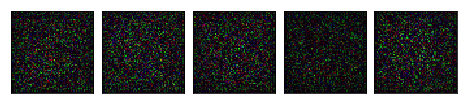

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 10, 'data_label': 1, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.002, 'betas': (0.4, 0.999)}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 1.1676883627386654
Generator loss:     2.111170761725482


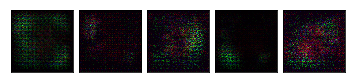

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.7028174575637368
Generator loss:     4.1032670105204865


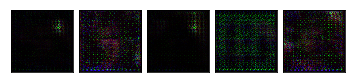

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.83it/s]
Discriminator loss: 0.6594533920288086
Generator loss:     4.302713962162242


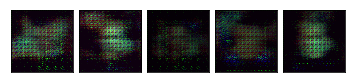

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
Discriminator loss: 1.0030818266027115
Generator loss:     2.5518466725068936


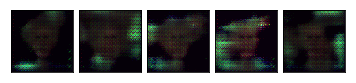

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.4588170647621155
Generator loss:     4.997636318206787


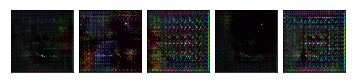

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.34951377177939696
Generator loss:     6.257720442379222


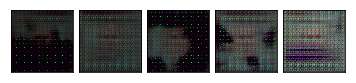

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.7754882547785255
Generator loss:     4.775233489625594


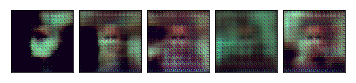

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.5244129072217381
Generator loss:     4.640052585040822


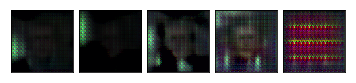

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.81it/s]
Discriminator loss: 0.4613591634175357
Generator loss:     5.207914128023035


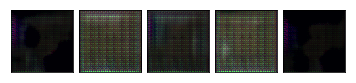

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
Discriminator loss: 0.29217293727047305
Generator loss:     5.406896422891056


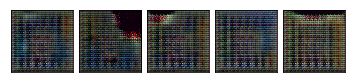

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.25973239212351684
Generator loss:     5.789375221028047


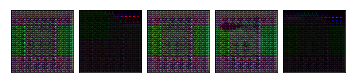

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.23213275938349612
Generator loss:     6.304898149826947


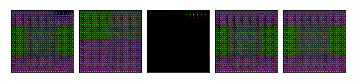

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.17667487176025615
Generator loss:     7.577297210693359


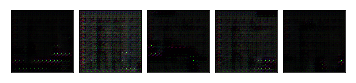

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.16685589534394882
Generator loss:     8.04945146336275


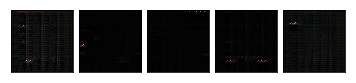

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.2092480983804254
Generator loss:     7.311563491821289


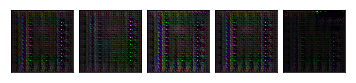

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.37115299964652343
Generator loss:     7.593161302454331


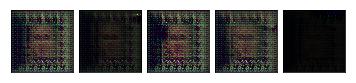

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.33660440891981125
Generator loss:     7.9833692662856155


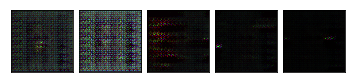

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.22744445152142467
Generator loss:     6.374170864329619


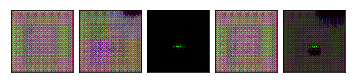

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.2751398884198245
Generator loss:     6.141132102293127


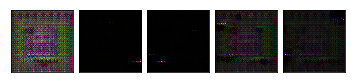

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.1989496696521254
Generator loss:     8.599576697630042


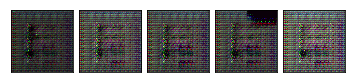

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.5369882964912582
Generator loss:     6.547895789146423


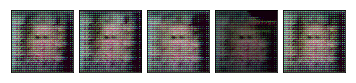

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.7987699219409157
Generator loss:     4.648993029313929


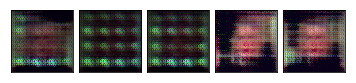

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 0.8738576278967016
Generator loss:     3.5192369099925545


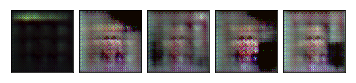

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.830759857507313
Generator loss:     4.366063552744248


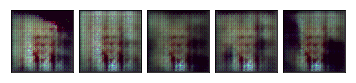

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
Discriminator loss: 0.898479501990711
Generator loss:     4.278019203859217


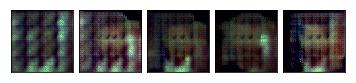

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.3801938238389352
Generator loss:     5.622662993038402


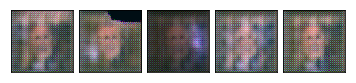

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.7435873308602501
Generator loss:     5.300679823931525


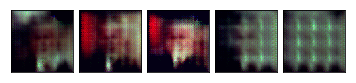

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.45588130460065956
Generator loss:     5.139812623753267


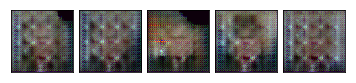

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.5720020444954143
Generator loss:     4.747609643375172


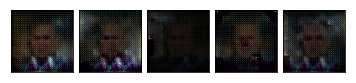

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.34154388220871196
Generator loss:     4.752848204444437


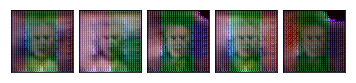

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.5152605929795433
Generator loss:     5.592697655453401


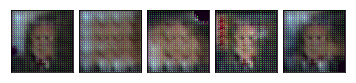

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.8373814716058618
Generator loss:     4.306730733198278


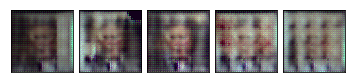

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.5938523858785629
Generator loss:     4.829413834740134


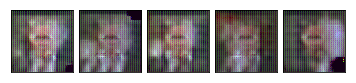

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.1172130563679863
Generator loss:     3.3106751301709343


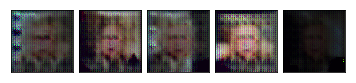

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.6237390462089988
Generator loss:     3.7019018986645866


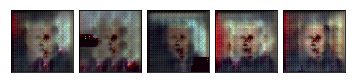

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.9626553304055158
Generator loss:     2.9445495807072697


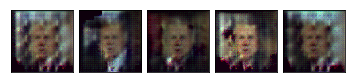

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.73it/s]
Discriminator loss: 1.1090831686468685
Generator loss:     2.456915252348956


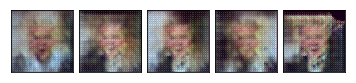

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 0.7888368981726029
Generator loss:     3.0718115427914787


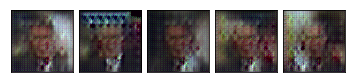

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.3674009284552406
Generator loss:     4.801172635134528


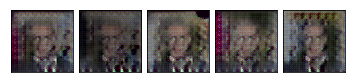

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.7482624658766914
Generator loss:     4.545734252999811


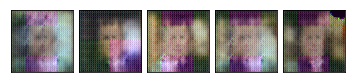

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.2230843480895548
Generator loss:     1.6817689467878902


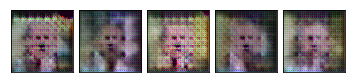

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.52it/s]
Discriminator loss: 1.0214482335483326
Generator loss:     2.604095196022707


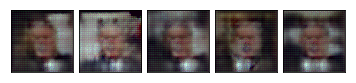

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.51it/s]
Discriminator loss: 0.9702747709610883
Generator loss:     2.5289367998347565


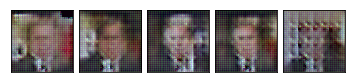

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.42it/s]
Discriminator loss: 1.1549994086518007
Generator loss:     2.5457768107161804


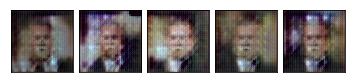

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.9490317877601174
Generator loss:     2.5877131504171036


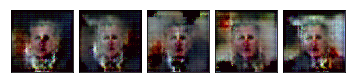

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.6793381063377156
Generator loss:     3.5877903209013096


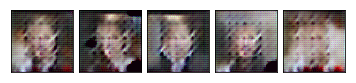

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.0153406209805433
Generator loss:     3.2560469578294193


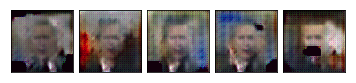

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 1.3148889874710756
Generator loss:     1.8315595291993196


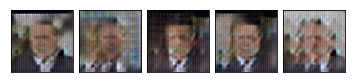

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1523117668488447
Generator loss:     1.8937161459642298


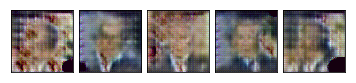

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1174123111893148
Generator loss:     2.2998298196231617


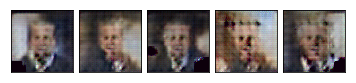

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 0.8658835870378158
Generator loss:     2.6698863804340363


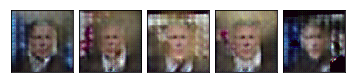

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.42it/s]
Discriminator loss: 1.2967107892036438
Generator loss:     1.7365323392783893


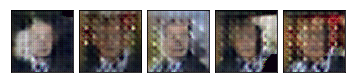

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 1.0843579067903406
Generator loss:     2.355617519687204


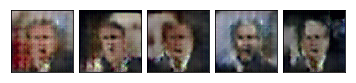

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0518323077875025
Generator loss:     2.485067490269156


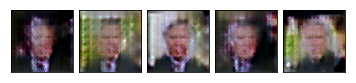

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1552964624236612
Generator loss:     2.0074057824471416


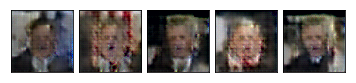

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 1.076267775367288
Generator loss:     2.1847619624698864


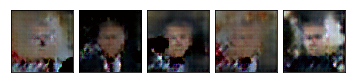

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.1571900353712194
Generator loss:     1.9487510393647587


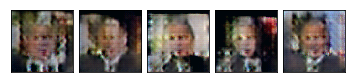

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.2613226280492895
Generator loss:     1.5443827562472399


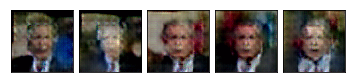

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.202972643515643
Generator loss:     1.6235191997359781


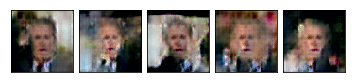

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1005360729554121
Generator loss:     1.8939367182114546


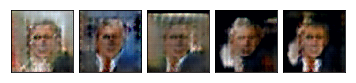

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.200725695666145
Generator loss:     1.9174882699461544


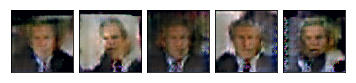

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.1627780444481794
Generator loss:     1.79253068040399


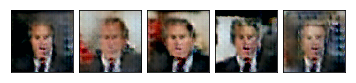

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.2479676709455603
Generator loss:     1.4511236338054432


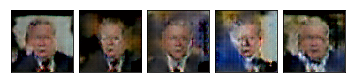

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.1054301682640524
Generator loss:     1.8642689340254839


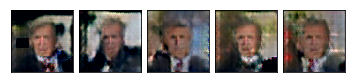

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.2236328545738668
Generator loss:     1.7108659902039696


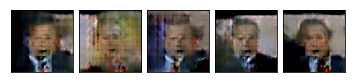

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.1737966607598698
Generator loss:     1.3395934981458328


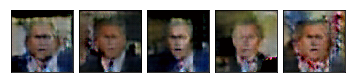

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0665153229937834
Generator loss:     2.0005502595621


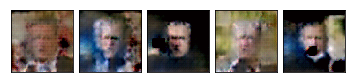

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.2040945852504057
Generator loss:     1.7301192844615263


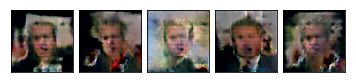

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
Discriminator loss: 1.2292810853789835
Generator loss:     1.5701727726880241


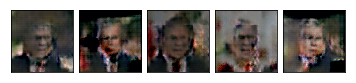

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 1.0709424825275646
Generator loss:     1.9804082793347977


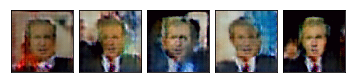

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1427678115227644
Generator loss:     1.7541415340760176


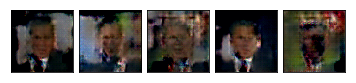

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.1969016474836014
Generator loss:     1.7375823224292082


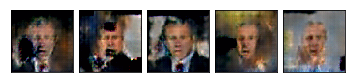

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:07<00:00,  2.37it/s]
Discriminator loss: 1.0659583316129797
Generator loss:     2.00871637989493


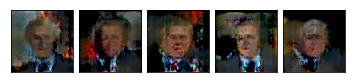

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
Discriminator loss: 1.0538657588117264
Generator loss:     2.062198709039127


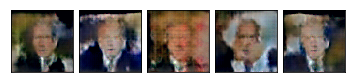

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.1195511712747461
Generator loss:     2.16416493584128


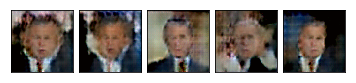

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0837089945288265
Generator loss:     2.1219066977500916


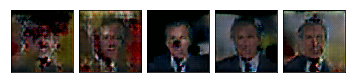

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.1367907208554886
Generator loss:     1.8845017377068014


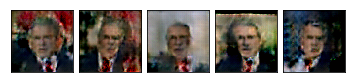

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.1263656581149382
Generator loss:     1.9178821865250082


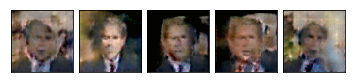

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.1291337784598856
Generator loss:     2.2082268245079937


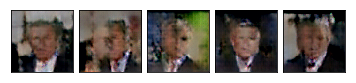

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.31it/s]
Discriminator loss: 1.131094680112951
Generator loss:     1.930354020174812


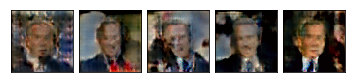

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.76it/s]
Discriminator loss: 1.0717337201623356
Generator loss:     2.1847135179183064


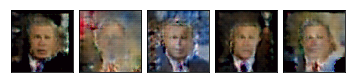

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.0738738635007072
Generator loss:     2.048039106761708


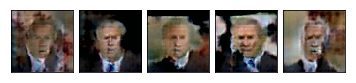

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.0721315951908337
Generator loss:     2.0536053391063915


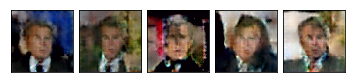

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.0407327168128069
Generator loss:     2.1428072031806495


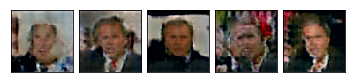

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 1.1301550234065336
Generator loss:     2.2806130437289966


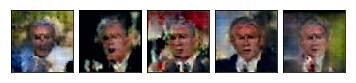

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 1.0435421642135172
Generator loss:     2.136062678168802


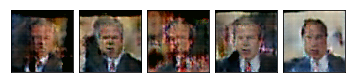

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.69it/s]
Discriminator loss: 1.0574601748410393
Generator loss:     2.2221498279010548


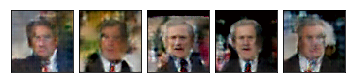

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 1.035667598247528
Generator loss:     2.24054211027482


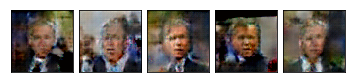

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
Discriminator loss: 1.0823254725512337
Generator loss:     2.1917345032972446


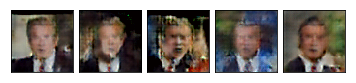

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.72it/s]
Discriminator loss: 0.9561804357696982
Generator loss:     2.428514277233797


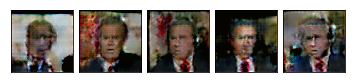

--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8999838758917416
Generator loss:     2.680593364378985


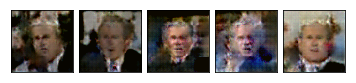

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 1.0445287998984842
Generator loss:     2.4727114579256844


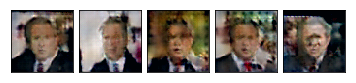

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.61it/s]
Discriminator loss: 0.9227275918511784
Generator loss:     2.586358056348913


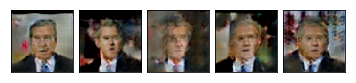

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.9978266814175774
Generator loss:     2.75112088988809


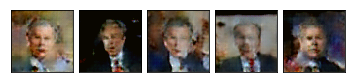

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.79it/s]
Discriminator loss: 0.9366654999115888
Generator loss:     2.6363752869998707


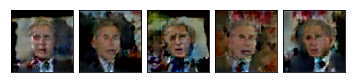

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
Discriminator loss: 0.8384156542665818
Generator loss:     2.9750043504378376


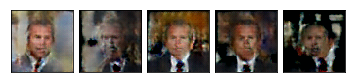

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.9425946842221653
Generator loss:     2.806153605966007


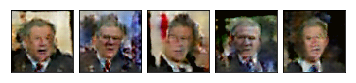

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.8488030293408562
Generator loss:     3.011649854042951


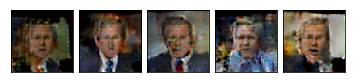

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.74it/s]
Discriminator loss: 0.8610703173805686
Generator loss:     3.2042810496161964


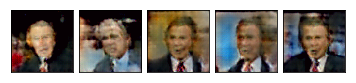

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:06<00:00,  2.77it/s]
Discriminator loss: 0.8517625752617332
Generator loss:     3.0218559293185963


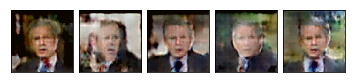

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


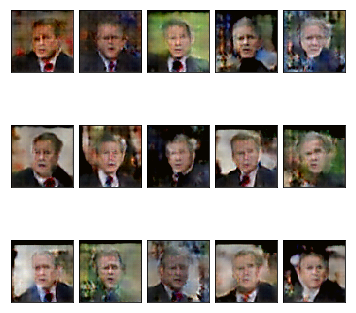

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [14]:
#from cs236605.answers import display_answer
#import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [15]:
#display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [16]:
#display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [17]:
#display_answer(hw3.answers.part3_q3)